In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt') # often useful for tokenization but i'm trying to use traditional ML

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
#load dataset

import zipfile
with zipfile.ZipFile('SMS Spam Classification.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Assuming the extracted file is named 'spam.csv' based on common naming conventions
# You might need to adjust this based on the actual file name inside the zip.
try:
    df = pd.read_csv('spam.csv', encoding='latin-1')
except UnicodeDecodeError:
    # Try a different encoding if latin-1 fails
    df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
except FileNotFoundError:
     print("The extracted file 'spam.csv' was not found. Please check the contents of the zip file.")
     df = None

if df is not None:
    # The dataset usually has columns 'v1' for label and 'v2' for text
    # Rename them for better readability
    df = df[['v1', 'v2']]
    df.columns = ['label', 'text']

    # Map labels to binary (0 for ham, 1 for spam)
    df['label'] = df['label'].map({'ham': 0, 'spam': 1})

    print("Dataset loaded successfully.")
    print(df.head())
    print("\nDataset Info:")
    df.info()
    print("\nLabel Distribution:")
    print(df['label'].value_counts())

Dataset loaded successfully.
   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   int64 
 1   text    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB

Label Distribution:
label
0    4825
1     747
Name: count, dtype: int64


Original DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   int64 
 1   text    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB

First 5 rows:
   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...

Column names before cleaning:
Index(['label', 'text'], dtype='object')

DataFrame Info after cleaning columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   la

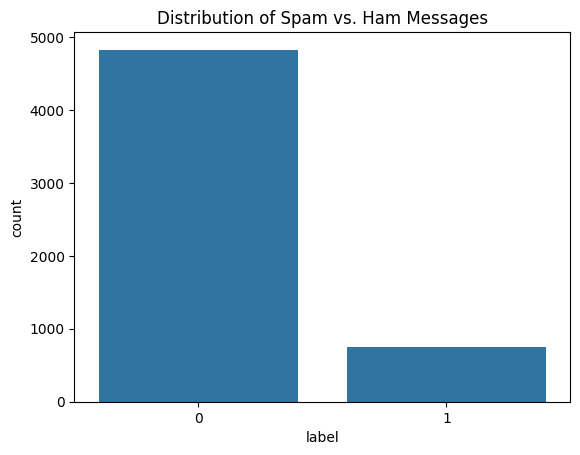

In [4]:
# Initial exploration
print("Original DataFrame Info:")
df.info()
print("\nFirst 5 rows:")
print(df.head())
print("\nColumn names before cleaning:")
print(df.columns)

# Drop unnecessary columns (often unnamed columns from CSV export)
df = df.iloc[:, :2] # Keep only the first two columns
df.columns = ['label', 'message'] # Rename columns for clarity

print("\nDataFrame Info after cleaning columns:")
df.info()
print("\nFirst 5 rows after cleaning columns:")
print(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Check label distribution
print("\nDistribution of labels:")
print(df['label'].value_counts())

# Visualize label distribution
sns.countplot(x='label', data=df)
plt.title('Distribution of Spam vs. Ham Messages')
plt.show()

In [6]:
# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # 1. Convert to lowercase
    text = text.lower()
    # 2. Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # 3. Tokenize (split into words)
    words = text.split()
    # 4. Remove stopwords and apply stemming (optional but recommended for traditional ML)
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    # 5. Join words back into a single string
    text = ' '.join(words)
    return text

# Apply preprocessing to the 'message' column
df['processed_message'] = df['message'].apply(preprocess_text)

print("\nOriginal vs. Processed Message Examples:")
print(df[['message', 'processed_message']].head())


Original vs. Processed Message Examples:
                                             message                                  processed_message
0  Go until jurong point, crazy.. Available only ...  go jurong point crazi avail bugi n great world...
1                      Ok lar... Joking wif u oni...                              ok lar joke wif u oni
2  Free entry in 2 a wkly comp to win FA Cup fina...  free entri 2 wkli comp win fa cup final tkt 21...
3  U dun say so early hor... U c already then say...                u dun say earli hor u c alreadi say
4  Nah I don't think he goes to usf, he lives aro...          nah dont think goe usf live around though


In [7]:
# Initialize TF-IDF Vectorizer
# max_features can be used to limit the number of features, which can help with memory and speed
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the processed messages
X = tfidf_vectorizer.fit_transform(df['processed_message'])

# Convert X to a DataFrame (optional, good for inspection)
X_df = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print("\nShape of TF-IDF features:", X.shape)
print("First 5 rows of TF-IDF features (sample):")
print(X_df.head())


Shape of TF-IDF features: (5572, 5000)
First 5 rows of TF-IDF features (sample):
   008704050406  01223585236  01223585334  0125698789  ...  ûªt  ûªv   ûï   ûò
0           0.0          0.0          0.0         0.0  ...  0.0  0.0  0.0  0.0
1           0.0          0.0          0.0         0.0  ...  0.0  0.0  0.0  0.0
2           0.0          0.0          0.0         0.0  ...  0.0  0.0  0.0  0.0
3           0.0          0.0          0.0         0.0  ...  0.0  0.0  0.0  0.0
4           0.0          0.0          0.0         0.0  ...  0.0  0.0  0.0  0.0

[5 rows x 5000 columns]


In [9]:
# Use the existing numerical 'label' column as the target variable
y = df['label']

print("\nLabel distribution:")
print(y.value_counts())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")


Label distribution:
label
0    4825
1     747
Name: count, dtype: int64

Training data shape: (4457, 5000), (4457,)
Testing data shape: (1115, 5000), (1115,)


Training Multinomial Naive Bayes...

--- Multinomial Naive Bayes Performance ---
Accuracy: 0.9668
Precision: 0.9912
Recall: 0.7584
F1-Score: 0.8593

Confusion Matrix:
[[965   1]
 [ 36 113]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.99      0.76      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115



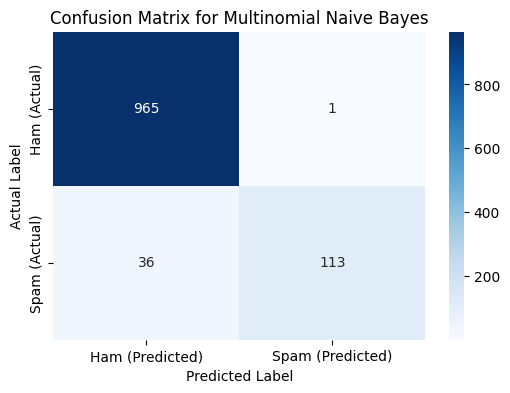


Training Logistic Regression...

--- Logistic Regression Performance ---
Accuracy: 0.9578
Precision: 0.9904
Recall: 0.6913
F1-Score: 0.8142

Confusion Matrix:
[[965   1]
 [ 46 103]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       966
           1       0.99      0.69      0.81       149

    accuracy                           0.96      1115
   macro avg       0.97      0.85      0.90      1115
weighted avg       0.96      0.96      0.95      1115



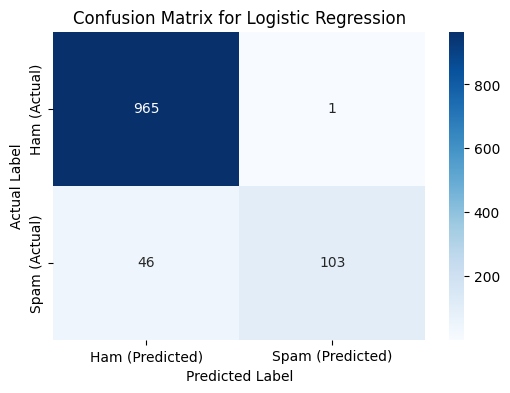


Training LinearSVC...

--- LinearSVC Performance ---
Accuracy: 0.9874
Precision: 1.0000
Recall: 0.9060
F1-Score: 0.9507

Confusion Matrix:
[[966   0]
 [ 14 135]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       1.00      0.91      0.95       149

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115



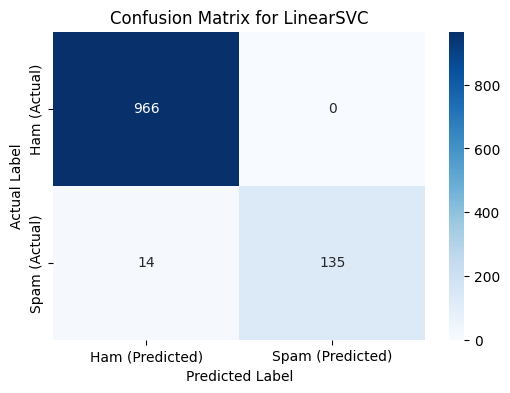


--- Model Performance Comparison ---
                         Accuracy  Precision    Recall  F1-Score
LinearSVC                0.987444   1.000000  0.906040  0.950704
Multinomial Naive Bayes  0.966816   0.991228  0.758389  0.859316
Logistic Regression      0.957848   0.990385  0.691275  0.814229


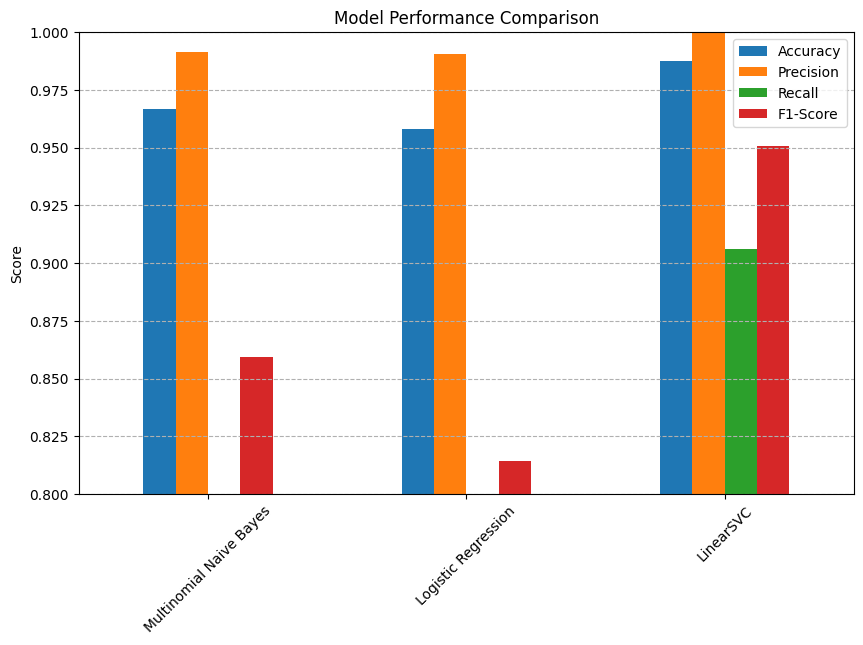


The best performing model based on accuracy is: LinearSVC
Reasons for its good performance (general observations):
- LinearSVC is often very effective with high-dimensional sparse data like TF-IDF vectors.
- Logistic Regression also performs well due to its linear decision boundary and regularization capabilities.
- Naive Bayes is a simple yet powerful probabilistic classifier, often a good baseline for text classification.
The differences in performance can be attributed to how each algorithm models the decision boundary and handles the feature space.


In [10]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\n--- {model_name} Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Ham (Predicted)', 'Spam (Predicted)'],
                yticklabels=['Ham (Actual)', 'Spam (Actual)'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy, precision, recall, f1

results = {}

# --- Multinomial Naive Bayes ---
print("Training Multinomial Naive Bayes...")
mnb_model = MultinomialNB()
mnb_model.fit(X_train, y_train)
acc, prec, rec, f1 = evaluate_model(mnb_model, X_test, y_test, "Multinomial Naive Bayes")
results["Multinomial Naive Bayes"] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1}

# --- Logistic Regression ---
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(solver='liblinear', random_state=42) # liblinear is good for small datasets
lr_model.fit(X_train, y_train)
acc, prec, rec, f1 = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")
results["Logistic Regression"] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1}

# --- Support Vector Machine (LinearSVC) ---
print("\nTraining LinearSVC...")
svc_model = LinearSVC(random_state=42, dual=False) # dual=False recommended for n_samples > n_features
svc_model.fit(X_train, y_train)
acc, prec, rec, f1 = evaluate_model(svc_model, X_test, y_test, "LinearSVC")
results["LinearSVC"] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1}

# Compare model performance
print("\n--- Model Performance Comparison ---")
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='Accuracy', ascending=False))

# Bar plot for comparison
results_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.8, 1.0) # Focus on the higher scores
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

# Explanation of best performing model
best_model_name = results_df['Accuracy'].idxmax()
print(f"\nThe best performing model based on accuracy is: {best_model_name}")
print("Reasons for its good performance (general observations):")
print("- LinearSVC is often very effective with high-dimensional sparse data like TF-IDF vectors.")
print("- Logistic Regression also performs well due to its linear decision boundary and regularization capabilities.")
print("- Naive Bayes is a simple yet powerful probabilistic classifier, often a good baseline for text classification.")
print("The differences in performance can be attributed to how each algorithm models the decision boundary and handles the feature space.")


--- Hyperparameter Tuning with GridSearchCV (for LinearSVC) ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best parameters for LinearSVC: {'C': 10}
Best cross-validation accuracy for LinearSVC: 0.9807

--- Optimized LinearSVC Performance ---
Accuracy: 0.9883
Precision: 0.9928
Recall: 0.9195
F1-Score: 0.9547

Confusion Matrix:
[[965   1]
 [ 12 137]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.99      0.92      0.95       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



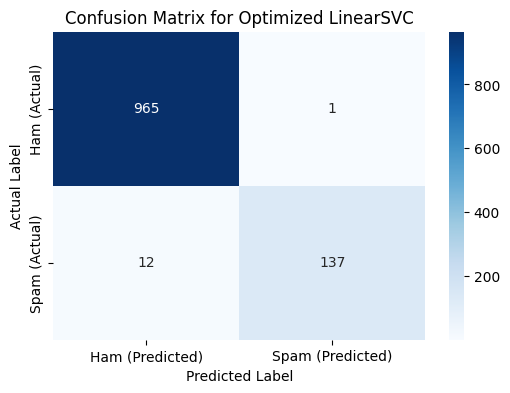


--- Hyperparameter Tuning with GridSearchCV (for Logistic Regression) ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters for Logistic Regression: {'C': 10, 'solver': 'saga'}
Best cross-validation accuracy for Logistic Regression: 0.9755

--- Optimized Logistic Regression Performance ---
Accuracy: 0.9839
Precision: 1.0000
Recall: 0.8792
F1-Score: 0.9357

Confusion Matrix:
[[966   0]
 [ 18 131]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.88      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



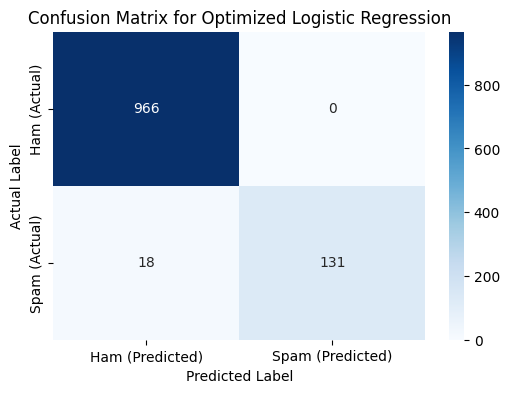


--- Model Performance Comparison (Including Optimized Models) ---
                               Accuracy  Precision    Recall  F1-Score
Optimized LinearSVC            0.988341   0.992754  0.919463  0.954704
LinearSVC                      0.987444   1.000000  0.906040  0.950704
Optimized Logistic Regression  0.983857   1.000000  0.879195  0.935714
Multinomial Naive Bayes        0.966816   0.991228  0.758389  0.859316
Logistic Regression            0.957848   0.990385  0.691275  0.814229


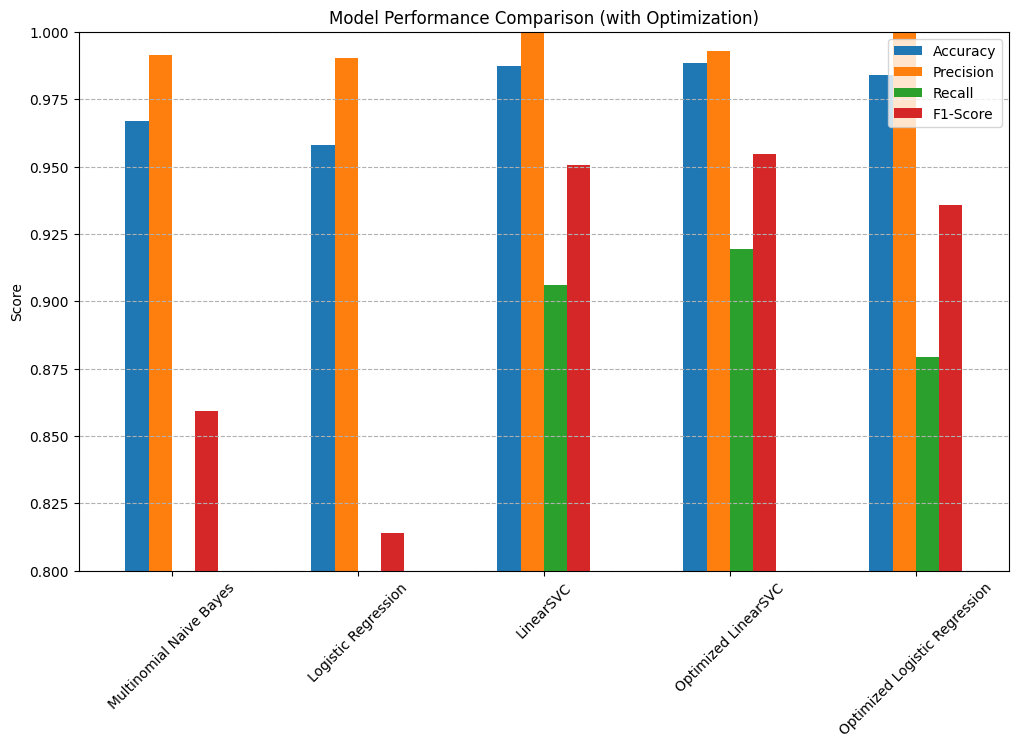

In [11]:
# Example: Optimizing LinearSVC
print("\n--- Hyperparameter Tuning with GridSearchCV (for LinearSVC) ---")
param_grid_svc = {
    'C': [0.1, 1, 10, 100], # Regularization parameter
    # 'loss': ['hinge', 'squared_hinge'] # 'squared_hinge' is default and usually good
}

grid_search_svc = GridSearchCV(LinearSVC(random_state=42, dual=False), param_grid_svc, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_svc.fit(X_train, y_train)

print(f"\nBest parameters for LinearSVC: {grid_search_svc.best_params_}")
print(f"Best cross-validation accuracy for LinearSVC: {grid_search_svc.best_score_:.4f}")

best_svc_model = grid_search_svc.best_estimator_
acc, prec, rec, f1 = evaluate_model(best_svc_model, X_test, y_test, "Optimized LinearSVC")
results["Optimized LinearSVC"] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1}

# Example: Optimizing Logistic Regression
print("\n--- Hyperparameter Tuning with GridSearchCV (for Logistic Regression) ---")
param_grid_lr = {
    'C': [0.1, 1, 10], # Inverse of regularization strength
    'solver': ['liblinear', 'saga'] # 'saga' handles L1/L2 and Elastic-Net
}

grid_search_lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_lr.fit(X_train, y_train)

print(f"\nBest parameters for Logistic Regression: {grid_search_lr.best_params_}")
print(f"Best cross-validation accuracy for Logistic Regression: {grid_search_lr.best_score_:.4f}")

best_lr_model = grid_search_lr.best_estimator_
acc, prec, rec, f1 = evaluate_model(best_lr_model, X_test, y_test, "Optimized Logistic Regression")
results["Optimized Logistic Regression"] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1}

# Re-compare all model performance including optimized ones
print("\n--- Model Performance Comparison (Including Optimized Models) ---")
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='Accuracy', ascending=False))

results_df.plot(kind='bar', figsize=(12, 7))
plt.title('Model Performance Comparison (with Optimization)')
plt.ylabel('Score')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()


--- Training VotingClassifier ---

--- VotingClassifier (Hard) Performance ---
Accuracy: 0.9740
Precision: 1.0000
Recall: 0.8054
F1-Score: 0.8922

Confusion Matrix:
[[966   0]
 [ 29 120]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.99      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



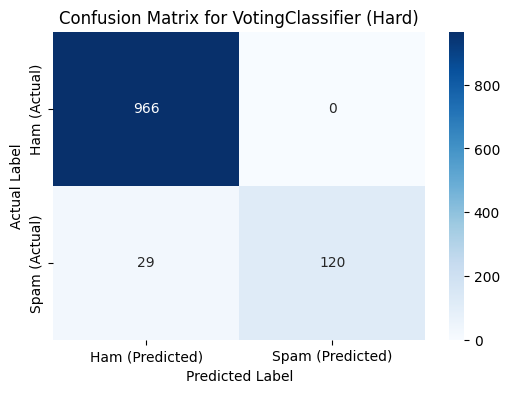


--- Final Model Performance Comparison (All Models) ---
                               Accuracy  Precision    Recall  F1-Score
Optimized LinearSVC            0.988341   0.992754  0.919463  0.954704
LinearSVC                      0.987444   1.000000  0.906040  0.950704
Optimized Logistic Regression  0.983857   1.000000  0.879195  0.935714
VotingClassifier (Hard)        0.973991   1.000000  0.805369  0.892193
Multinomial Naive Bayes        0.966816   0.991228  0.758389  0.859316
Logistic Regression            0.957848   0.990385  0.691275  0.814229


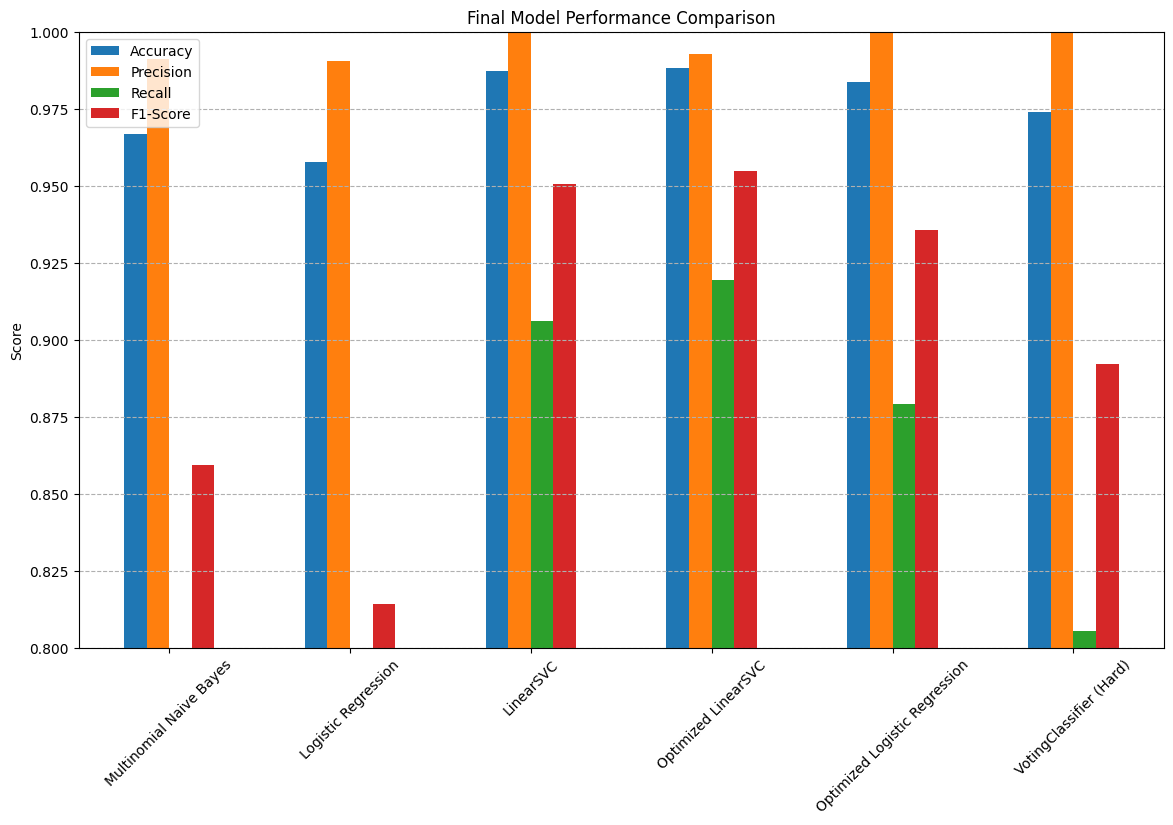

In [12]:
print("\n--- Training VotingClassifier ---")
# Choose the best performing individual models or a combination of strong ones
# Ensure models are trained (or use the best_estimator_ from GridSearchCV)
estimators = [
    ('mnb', MultinomialNB()),
    ('lr', LogisticRegression(solver='liblinear', C=1)), # Using a good C value, or best_lr_model
    ('svc', LinearSVC(random_state=42, C=1, dual=False)) # Using a good C value, or best_svc_model
]

# For soft voting, ensure that classifiers support predict_proba (MultinomialNB and LogisticRegression do, LinearSVC does not directly)
# If using LinearSVC, it's generally best to use 'hard' voting, or train a LogisticRegression with predict_proba for 'soft'
# If you want soft voting, ensure SVC is replaced with a version that supports predict_proba (e.g., CalibratedClassifierCV on LinearSVC or a different SVC kernel).
# For simplicity and compatibility with LinearSVC, let's stick to hard voting or use LR and MNB for soft.

# Let's use hard voting with the strong models (MNB, LR, LinearSVC)
voting_clf_hard = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)
voting_clf_hard.fit(X_train, y_train)

acc, prec, rec, f1 = evaluate_model(voting_clf_hard, X_test, y_test, "VotingClassifier (Hard)")
results["VotingClassifier (Hard)"] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1}

# (Optional) Soft Voting Example if all chosen models support predict_proba
# estimators_soft = [
#     ('mnb', MultinomialNB()),
#     ('lr', LogisticRegression(solver='liblinear', C=1, random_state=42, predict_proba=True))
# ]
# voting_clf_soft = VotingClassifier(estimators=estimators_soft, voting='soft', n_jobs=-1)
# voting_clf_soft.fit(X_train, y_train)
# acc, prec, rec, f1 = evaluate_model(voting_clf_soft, X_test, y_test, "VotingClassifier (Soft)")
# results["VotingClassifier (Soft)"] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1}


# Final Comparison
print("\n--- Final Model Performance Comparison (All Models) ---")
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='Accuracy', ascending=False))

results_df.plot(kind='bar', figsize=(14, 8))
plt.title('Final Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()